# Domain Adaptation - a brief review

Traditionally, in the supervised learning approach we are interested in approximating a function $f: X \longrightarrow Y$ by means of using a training sample of the random vectors (or feature space) $X_{\text{train}}$, this is typically done by optimizing some *cost* function on unseen *test* data.
By doing this we are (naively) assuming that both the training and test samples are drawn from the same joint probability distribution. Real world, though, is harsh and this is typically not the case. In particular, once we have trained our ML model, we cannot assure that the *real-world* data that this model will see in production it is drawn from the same joint probability distribuition as the training data. This can happen for several reasons, such as:
* Joint probabilities of the domain can, and most probably will, change with time.
* Training samples collection might have unknown biases due to different selection methods, for instance.
* We might need to generalize a model to a completely new domain, e.g., use training data from Brazil to build a model for Mexico.
* ...

In all above examples, the training samples are not an accurate representation of the actual examples that the model will see in real-life. Naturally, this will translate into a performance degradation of the model that could worsen with time. To tackle this problem, several techniques under the name of **domain adaptation** were developed. From now on, we will refer to the training and test samples as *source* and *target* distributions. 

Domain adaptation is a special case of **transfer learning**. Transfer learning refers to a class of machine learning problems where the tasks and/or domains may change between source and target whereas domain adaptation only is interested in problems where the domains differ and tasks remain the same between source and target distributions. Also, semi-supervised learning adresses the problem of having unlabeled data, In this setup, a small set of labeled data is used together to a big amount of unlabeled data to train a model. Moreover, both labeled and unlabeled data are assumed to have being drawn from the same joint probability distribution, an assumption that is relaxed in the domain adaptation and transfer learning setups.

In this notebook we will discuss the basic ideias under **Domain adaptation**, the discussion will be motivated by practical (synthetic) examples and at the end we will show how domain adaptation was used on a practical example at the DataLab.
Let us begin by stating the problem in general terms by defining the essential mathematical objects under study in this context.


# Notation and definitions
In domain adaptation, domains consists of three general ingredients:
* Input or feature space $X$, e.g. $X \subset \mathbb{R}^d$.
* output or label sabes $Y$, e.g. $Y = \{0,1\}$ for binary classification tasks, $Y = \{0, 1, \dots, k-1\}$ for k-class classification tasks, and $Y \subset \mathbb{R}$ for regression tasks.
* and an associated joint probability distribution $\mathcal{D}=\{X, Y, \mathbb{P}(X=x,Y=y)\}$, where $\mathbb{P}(X=x,Y=y)$ is the probability density.

For simplicity we will write $\mathbb{P}(X= x, Y = y)$ as $\mathbb{P}(x,y)$. Recall that we can write the joint probability density as:
\begin{align*}
\mathbb{P}(x,y) &= \mathbb{P}(x|y) \mathbb{P}(y), \\
& = \mathbb{P}(y|x)\mathbb{P}(x),
\end{align*}
where $\mathbb{P}(x|y)$ and $P(y|x)$ are conditional probability density functions also called *likelihood* and *posterior* probability distributions in the Bayesian framework.

Denote the source and target distributions (domains) by $\mathcal{D}_{S}$ and $\mathcal{D}_{T}$, respectively. Consequently, the training (source) dataset is comprised of samples $\{x_i, y_i\}_{i=1}^{n}$ drawn from the source distribution $\mathcal{D}_{S}$ while the test (target) dataset is composed of samples $\{x_j, y_j\}_{j=1}^{m}\sim \mathcal{D}_{T}$ drawn from the target distribution. Note that the case for which the labels for the target distribution are not known is called **unsupervised domain adaptation**.

Domain adaptation's goal is to learn a generalized classifier (or regressor) in the presence of data drift between the source and target distributions. In general, a machine learning model's objective is to learn a function $f: X \longrightarrow Y $ from a set of functions $f \in \mathcal{H}$, where $\mathcal{H}$ is the **hypothesis space** of all possible functions. Dependending on the nature of the the label space $Y$, the task is called *classification* or *regression*. So far our discussion is independent of whether we are dealing with a classification or a regression task. 

So, to find the best function $f$ we usually find the best parameters (or entropy splits) by minimizing the expected risk functions (or loss) on the *source* labeled dataset, this is:
\begin{align*}
R_{S}(f) = \mathbb{E}_{(x,y)\sim \mathcal{D}_S}\left[\;l(f(x), y)\;\right],
\end{align*}
where $l(f(x),y)$ is some loss appropriate loss function. Without loss of generality we can assume that we are working with a classification task so the label space $Y$ is actually discrete. Likewise, we assume the feature space is a subset of $d-$ dimensional Euclidean space $X \subset \mathbb{R}^d$. So we can write:
\begin{align*}
R_{S}(f) = \sum_{y \in Y} \int_{X} l(\,f(x), y\,)\; \mathbb{P}_S(x,y) dx.
\end{align*}
Recall that, in practice, we actually estimate the above quantity by the empirical risk (or loss) function that is computed on the training samples. Now, remember that our goal is to learn a model that performs well on the *target* domain. In other words, we would like to minimize the following expectation value:
\begin{align*}
R_{T}(f) &= \mathbb{E}_{(x,y)\sim \mathcal{D}_T}\left[\;l(f(x), y)\;\right]\\
&= \sum_{y \in Y} \int_{X} l(\,f(x), y\,)\; \mathbb{P}_T(x,y) dx,
\end{align*}
rewriting the last expression on the r.h.s as:
\begin{align*}
R_{T}(f) &= \sum_{y \in Y} \int_{X} l(\,f(x), y\,)\; \mathbb{P}_T(x,y) \dfrac{\mathbb{P}_S(x,y)}{\mathbb{P}_S(x,y)} dx,\\
&= \sum_{y \in Y} \int_{X} l(\,f(x), y\,)\; \mathbb{P}_S(x,y) \dfrac{\mathbb{P}_T(x,y)}{\mathbb{P}_S(x,y)} dx,\\
&= \mathbb{E}_{(x,y)\sim \mathcal{D}_P}\left[\; \dfrac{\mathbb{P}_T(x,y)}{\mathbb{P}_S(x,y)}\, l(f(x), y)\;\right].
\end{align*}
where $\mathbb{P}_S(x,y)$ and $\mathbb{P}_S(x,y)$ are the source and target joint probability density functions. Notice how we have actually rewritten the expectation value $\mathbb{E}_{(x,y)\sim \mathcal{D}_T}$ as an expectation $\mathbb{E}_{(x,y)\sim \mathcal{D}_P}$ by means of a **Radon-Nikodim** derivative. The above expression is the main idea behind **Domain Adaptation**. Moreover, when we assume that both the source and target domains are equivalent, as it is typically done, the term:
$$\frac{\mathbb{P}_T(x,y)}{\mathbb{P}_S(x,y)} = 1.$$



# Classification of Domain Adaptation

There is a general classification into *closed*, *open* and *partial* set domain adaptation. They basically have to do with the source and target domains sharing the same label space classes for classification tasks. For this discussion we will focus on the so called *closed set domain adaptation* problems, where the label set $Y$ is shared between the source and target domains and we refer the curious reader to [this review](https://arxiv.org/abs/2010.03978) and the references therein for the open set domain adaptation case. Furthermore, [this repository](https://github.com/zhaoxin94/awesome-domain-adaptation) has a plethora of references about the domain adaptation literature, examples and tutorials.

Let us go back to the main domain adaptation expression, this is, the risk or loss function we would like to minimize while training our ML model:
\begin{align*}
R_{T}(f) = \mathbb{E}_{(x,y)\sim \mathcal{D}_P}\left[\; \dfrac{\mathbb{P}_T(x,y)}{\mathbb{P}_S(x,y)}\, l(f(x), y)\;\right],
\end{align*}
the way the joint probability distributions $\mathcal{D}_S$ and $\mathcal{D}_T$ differ from each other will determine the class of domain adaptation we are actually dealing with. To see this, let us focus on the probability density ratio between source and target distributions, this is:
\begin{align*}
\omega(x,y) &= \dfrac{\mathbb{P}_T(x,y)}{\mathbb{P}_S(x,y)} \\
&= \dfrac{\mathbb{P}_T(x|y)\mathbb{P}_T(y)}{\mathbb{P}_S(x|y)\mathbb{P}_S(y)}\\
&= \dfrac{\mathbb{P}_T(y|x)\mathbb{P}_T(x)}{\mathbb{P}_S(y|x)\mathbb{P}_S(x)}.
\end{align*}
## Label Shift
In the case the joint distribution differ only in the label marginal distributions, this is, $\mathbb{P}_S(y) \neq \mathbb{P}_T(y)$ while the posterior distributions are equivalent $\mathbb{P}_T(x|y) = \mathbb{P}_S(x|y)$ is called **label shift**. A familiar example could be that of a class imbalance difference between source and target domains in the binary classification setup. In this case the density ratio reads:
$$\omega(y) = \dfrac{\cancel{\mathbb{P}_T(x|y)}\;\mathbb{P}_T(y)}{\cancel{\mathbb{P}_S(x|y)}\;\mathbb{P}_S(y)} = \dfrac{\mathbb{P}_T(y)}{\mathbb{P}_S(y)}.$$
This might seem a very simple weight to calculate and use for the loss function estimation at training time. It requires, however, knowledge of the target domain labels $Y_T$ which might not be easy to get, or in some cases impossible to have access to.

## Covariate Shift
This is the case when we assume the source and target joint distributions differ only through the covariate marginal distribution, namely, $\mathbb{P}_S(y) \neq \mathbb{P}_T(y)$ 
while we assume the source and target likelihoods are equivalent $\mathbb{P}_T(y|x) = \mathbb{P}_S(y|x)$. So, for the density ratio we have:
$$\omega(x) = \dfrac{\cancel{\mathbb{P}_T(y|x)}\;\mathbb{P}_T(x)}{\cancel{\mathbb{P}_S(y|x)}\;\mathbb{P}_S(x)} = \dfrac{\mathbb{P}_T(x)}{\mathbb{P}_S(x)}.$$

In this scenario, we do not need acces to the target label values. However, the assumption that the source and target likelihoods are the same might not be always true. 

## Concept Shift (types I and II)
Source and target distributions could also differ through the conditional probability distributions in two different ways, coined *type I* and *type II*. 
* **Type I** concept shift occurs when the difference between source and target distributions is due to the likelihoods, this is $\mathbb{P}_S(x|y) \neq \mathbb{P}_T(x|y)$ while the label marginal distributions are equal $\mathbb{P}_S(y) = \mathbb{P}_T(y)$, which yields for the density ratio:
$$\omega(x,y) = \dfrac{\mathbb{P}_T(x|y)\;\cancel{\mathbb{P}_T(y)}}{\mathbb{P}_S(x|y)\;\cancel{\mathbb{P}_S(y)}} = \dfrac{\mathbb{P}_T(x|y)}{\mathbb{P}_S(x|y)}.$$

* **Type II** concept shift occurs when the difference between source and target distributions is due to the posterior distributions, this is $\mathbb{P}_S(y|x) \neq \mathbb{P}_T(y|x)$ while the covariate marginal distributions are the same $\mathbb{P}_S(x) = \mathbb{P}_T(x)$, this will result in the following density ratio:
$$\omega(x,y) = \dfrac{\mathbb{P}_T(y|x)\;\cancel{\mathbb{P}_T(x)}}{\mathbb{P}_S(y|x)\;\cancel{\mathbb{P}_S(x)}} = \dfrac{\mathbb{P}_T(y|x)}{\mathbb{P}_S(y|x)}.$$

Both concept shift types require a knowledge of the conditional distributions which in turn requires a knowledge of both the feature and label spaces for the source and target domains.

More generally, the joint distributions could differ in ways that are not factorable in neither label shift, covariate shift nor concept shift. In such cases we are talking about *total dataset shift* and computing the density ratio $\omega(x,y)$ would require access the both domain and target joint distributions and *density ratio estimation* techniques are the usual methods for tackling these cases. A unified framework for detecting dataset shift is proposed in [Polo 2022](https://arxiv.org/abs/2205.08340) using the Kullback-Leibler divergence as an statistic for measuring all types of dataset shift. Morevoer, a ready-to-use python package can be found in this [repository](https://github.com/felipemaiapolo/detectshift). In the following section, we will go through some practical (synthetic) examples of actual domain adaptation.


# Examples

In [1]:
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

In [2]:
import matplotlib as mpl

# Plotting syle
plt.style.use('dark_background')

# Plotting functions
def clean_ax(ax, clean_all : bool = False, inverted : bool = False):
    """
    Cleans the borders of a matplotlib.axis object.
    Parameters
    ----------
    ax: matplotlib.axis
        axis object to be modified
    clean_all: boolean (default = False)
        whether to clean the entire boundary
    inverted: boolean (default = False)
        whether to clean bottom and right borders
    """
    if clean_all:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)    
        ax.spines['bottom'].set_visible(False)
    elif inverted:
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return ax

# Covariate Shift: Regression example
For this example we will consider a single variable regression model of the form:
$$y = f(x)+ \epsilon,$$

where $f$ is the function we are trying to approximate and $\epsilon$ is a gaussian error term. So we will start by constructing some auxiliar functions that will generate the training  data. To be able to force the covariate shift between source and target distributions, we will consider the covariate $X \sim \text{Beta}(a, b)$ and vary the $a, b$ parameters between source and target domains. The actual function we are trying to estimate will be a sine function of the form:



In [144]:
def func(x):
    """wrapper for a simple a cosine function"""
    return np.cos(2* np.pi * x)

def get_X_y(a:float = 2, b:float = 4, sample_size: int = 50):
    """Produces the X and y sample given the beta 
    distribution parameters and the sample size
    Parameters
    ----------
    a: float (default = 2)
        Beta `a` parameter, must be >0
    b: float (default = 4)
        Beta `b` parameters, must be >0
    sample_size: int (deafult = 50)
        size of the sample to be generated

    Returns
    -------
    X: list[float]
        Covariate samples
    y: list[float]
        Response variable samples
    """
    X = np.random.beta(a,b, sample_size) 
    y = func(X) + np.random.normal(0, 0.3, size = sample_size)
    return X, y

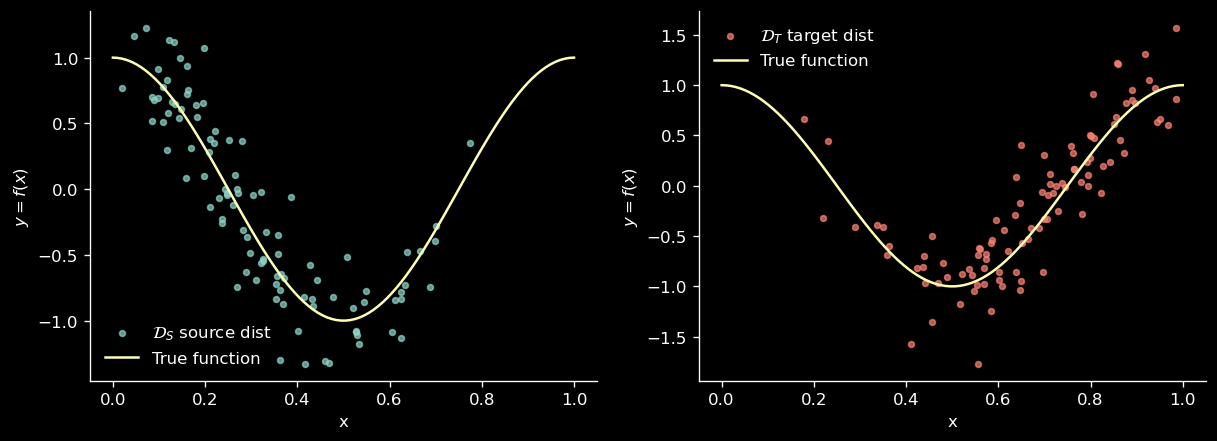

In [204]:
# construct the source dataset for visualization
size = 100
X_s, y_s = get_X_y(2, 4, size)
X_t, y_t = get_X_y(4, 2, size)


f, ax = plt.subplots(1,2, dpi = 120, figsize = (12,4))
ax[0].scatter(X_s, y_s, alpha = 0.7, marker = 'o', s = 12, label = r'$\mathcal{D}_S$ source dist')
X_lin = np.linspace(0, 1, size)
ax[0].plot(X_lin, func(X_lin), c = 'C1', label = 'True function')
ax[0].legend(loc = 'best', frameon = False)
ax[0].set_ylabel(r'$y = f(x)$')
ax[0].set_xlabel('x')
clean_ax(ax[0])


ax[1].scatter(X_t, y_t, alpha = 0.7, c = 'C3', marker = 'o', s = 12, label = r'$\mathcal{D}_T$ target dist')
ax[1].plot(X_lin, func(X_lin), c = 'C1', label = 'True function')
ax[1].legend(loc = 'best', frameon = False)
ax[1].set_ylabel(r'$y = f(x)$')
ax[1].set_xlabel('x')
clean_ax(ax[1])

plt.show()


To have a look at the difference between the covariate source and target distributions let us plot a couple of histograms from $X \sim \mathcal{D}_S$ and $X \sim \mathcal{D}_T$:

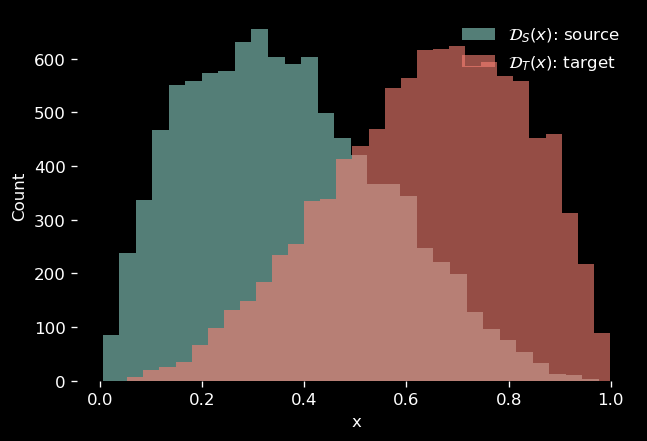

In [211]:
size = int(1e4)
X_s, y_s = get_X_y(2, 3.5, size)
X_t, y_t = get_X_y(3.5, 2, size)

f, ax = plt.subplots(dpi = 120, figsize = (6,4))
ax.hist(X_s, bins = 30, alpha = 0.6, label = r'$\mathcal{D}_S(x)$: source')
ax.hist(X_t, color ='C3', bins = 30, alpha = 0.6, label = r'$\mathcal{D}_T(x)$: target')
clean_ax(ax, clean_all = True)
ax.legend(loc = 'best', frameon = False)
ax.set_ylabel('Count')
ax.set_xlabel('x')
plt.show()


Now, let us actually train a linear regression model on the source distribution $\mathcal{D}_S$ and compute the generalization error (MSE) on the target distribution $\mathcal{D}_T$:

In [212]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

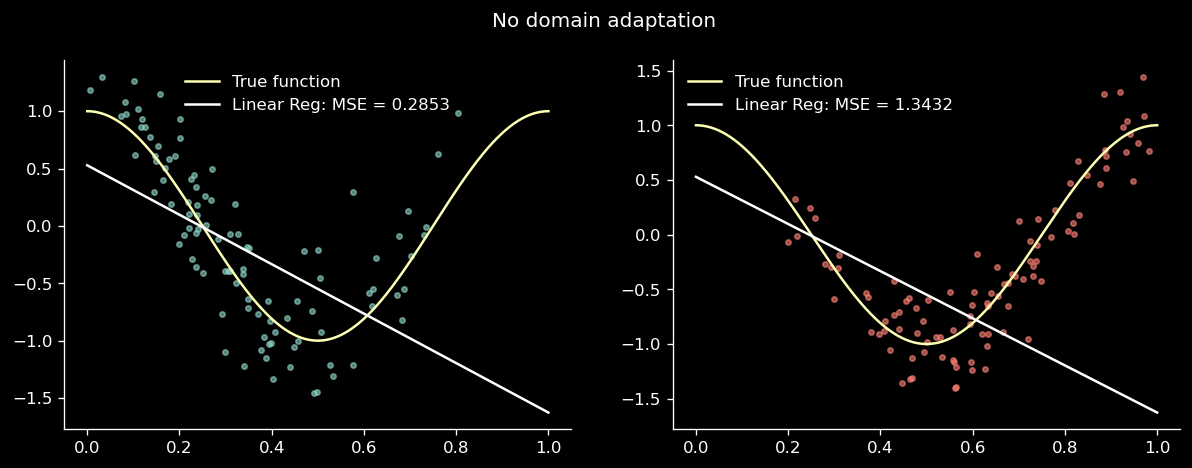

In [216]:
# instantiate the object
lr = LinearRegression()
# fit the model
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3)
lr.fit(X_train.reshape(-1,1), y_train)
mse_s = mean_squared_error(y_test, lr.predict(X_test.reshape(-1,1)))

# predict on target data
y_pred = lr.predict(X_t.reshape(-1,1))
mse_t = mean_squared_error(y_t, y_pred)

X_lin = np.linspace(0, 1, num = size)
# Visualization
f, ax = plt.subplots(1,2, dpi = 120, figsize = (12,4))
ax[0].scatter(X_s[:100], y_s[:100], alpha = 0.6, s = 10)
ax[0].plot(X_lin, func(X_lin), c = 'C1', label = 'True function')
ax[0].plot(X_lin, lr.predict(X_lin.reshape(-1,1)), c = 'w', label= f'Linear Reg: MSE = {mse_s:.4f}')
ax[0].legend(loc = 'best', frameon = False)
clean_ax(ax[0])

ax[1].scatter(X_t[:100], y_t[:100], c = 'C3', alpha = 0.6, s = 10)
ax[1].plot(X_lin, func(X_lin), c = 'C1', label = 'True function')
ax[1].plot(X_lin, lr.predict(X_lin.reshape(-1,1)), c = 'w', label= f'Linear Reg: MSE = {mse_t:.4f}')
ax[1].legend(loc = 'best', frameon = False)
clean_ax(ax[1])

f.suptitle('No domain adaptation')
plt.show()

Now, let us apply domain adaptation to the linear regression training by weighting the loss function with the density ratio:
$$\omega(x) = \dfrac{\mathbb{P}_T(x)}{\mathbb{P}_S(x)},$$
for our toy example this can be done analytically, since we know the covariate distributions beforehand. To do so, we will use `scipy`'s beta module as follows:


In [217]:
from scipy.stats import beta

def get_w_from_pdf(x, a_s, b_s, a_t, b_t):
    """given a sample x and the beta parameters computes the
    probability density ratio 
    """
    p_s = beta.pdf(x, a = a_s, b = b_s)
    p_t = beta.pdf(x, a = a_t, b = b_t)

    w = p_t/p_s
    
    return w

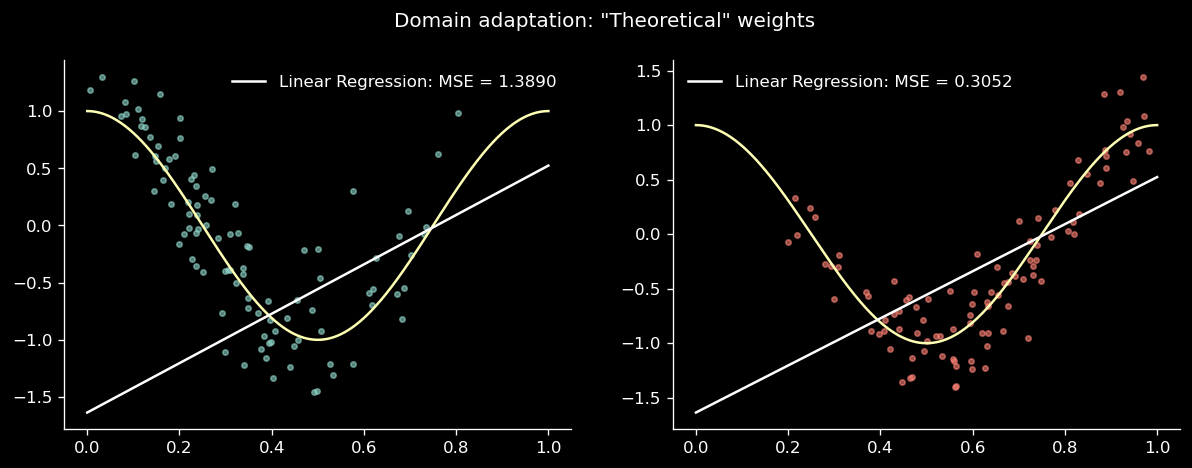

In [224]:
# instantiate the object
lr = LinearRegression()
# fit the model
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3)
a_s = 2 ; b_s = 3.5
a_t = 3.5 ; b_t = 2
weights = get_w_from_pdf(X_train, a_s, b_s, a_t, b_t)
lr.fit(X_train.reshape(-1,1), y_train, sample_weight = weights)
mse_s = mean_squared_error(y_test, lr.predict(X_test.reshape(-1,1)))

# predict on target data
y_pred = lr.predict(X_t.reshape(-1,1))
mse_t = mean_squared_error(y_t, y_pred)

X_lin = np.linspace(0, 1, num = size)
# Visualization
f, ax = plt.subplots(1,2, dpi = 120, figsize = (12,4))
ax[0].scatter(X_s[:100], y_s[:100], alpha = 0.6, s = 10)
ax[0].plot(X_lin, func(X_lin), c = 'C1')
ax[0].plot(X_lin, lr.predict(X_lin.reshape(-1,1)), c = 'w', label= f'Linear Regression: MSE = {mse_s:.4f}')
ax[0].legend(loc = 'best', frameon = False)
clean_ax(ax[0])

ax[1].scatter(X_t[:100], y_t[:100], c = 'C3', alpha = 0.6, s = 10)
ax[1].plot(X_lin, func(X_lin), c = 'C1')
ax[1].plot(X_lin, lr.predict(X_lin.reshape(-1,1)), c = 'w', label= f'Linear Regression: MSE = {mse_t:.4f}')
ax[1].legend(loc = 'best', frameon = False)
clean_ax(ax[1])
f.suptitle('Domain adaptation: "Theoretical" weights')
plt.show()

We can see that including weights to the linear regression fit process improves the performance in the target domain, as we expected. However, the weights were computed by hand because we knew the covariate distributions from the beginning. This will never be the case on real-life situations. To tackle this issue, there are several density ratio estimation techniques such as **kernel density estimation**, **kernel mean matching** and the **probabilistic classifaction approach** that we will illustrate in the following lines. For more details on density ratio estimation methods we refer the curiuous reader to [this](http://www.ms.k.u-tokyo.ac.jp/sugi/2010/RIMS2010.pdf) review. 

A clever way to estimate the probability density ratio:
$$\omega(x) = \dfrac{\mathbb{P}_T(x)}{\mathbb{P}_S(x)},$$
is to train a probabilistic classifier whose objective is to classify whether a sample $x$ belongs to the source distribution $\mathcal{D}_S$ or to the target distribution $\mathcal{D}_T$, and then use this models outputs as weights for the actual regression model. In order to train such classifier we need to construct a target variable with the following behavior:
\begin{align*}
t(x) = \begin{cases}0\;\; \text{if } x \sim \mathcal{D}_S \\
                    1\;\; \text{if } x \sim \mathcal{D}_T \end{cases}
\end{align*}
considering this new random variable, we can write the density ratio as:
$$\omega(x) = \dfrac{\mathbb{P}_T(x)}{\mathbb{P}_S(x)} = \dfrac{\mathbb{P}(x | t =1)}{\mathbb{P}(x | t =0)},$$
apply Bayes' rule to each conditional probability, to get:
$$\mathbb{P}(x | t =1) = \dfrac{\mathbb{P}(t = 1 | x)\mathbb{P}(x)}{\mathbb{P}(t)},$$
substituting the above into the density ratio, we get:
$$\omega(x) = \dfrac{\mathbb{P}(t = 1 | x)}{\mathbb{P}(t = 0| x)}=\dfrac{\mathbb{P}(t = 1 | x)}{1 - \mathbb{P}(t = 1 | x)}.$$
Let's code this, begin by constructing the dataset that will be used to train the classifier.


In [221]:
from sklearn.linear_model import LogisticRegression
def get_w_from_classifier(X_train):
    """
    """

    t_s = np.zeros(shape = len(X_s))
    t_t = np.ones(shape = len(X_t))

    X_class = np.concatenate([X_s, X_t])
    t_class = np.concatenate([t_s, t_t])

    log_reg = LogisticRegression()
    log_reg.fit(X_class.reshape(-1,1), t_class)
    
    t_pred = log_reg.predict_proba(X_train.reshape(-1,1))[:,1]

    return t_pred/ (1- t_pred)


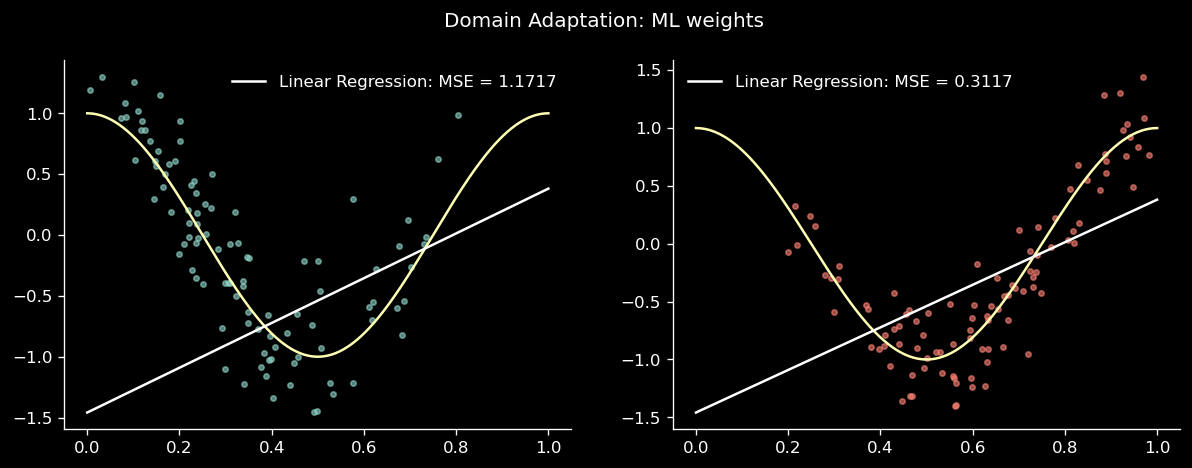

In [223]:
# instantiate the object
lr = LinearRegression()
# fit the model
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3)
weights_ml = get_w_from_classifier(X_train)
lr.fit(X_train.reshape(-1,1), y_train, sample_weight = weights_ml)
mse_s = mean_squared_error(y_test, lr.predict(X_test.reshape(-1,1)))

# predict on target data
y_pred = lr.predict(X_t.reshape(-1,1))
mse_t = mean_squared_error(y_t, y_pred)

X_lin = np.linspace(0, 1, num = size)
# Visualization
f, ax = plt.subplots(1,2, dpi = 120, figsize = (12,4))
ax[0].scatter(X_s[:100], y_s[:100], alpha = 0.6, s = 10)
ax[0].plot(X_lin, func(X_lin), c = 'C1')
ax[0].plot(X_lin, lr.predict(X_lin.reshape(-1,1)), c = 'w', label= f'Linear Regression: MSE = {mse_s:.4f}')
ax[0].legend(loc = 'best', frameon = False)
clean_ax(ax[0])

ax[1].scatter(X_t[:100], y_t[:100], c = 'C3', alpha = 0.6, s = 10)
ax[1].plot(X_lin, func(X_lin), c = 'C1')
ax[1].plot(X_lin, lr.predict(X_lin.reshape(-1,1)), c = 'w', label= f'Linear Regression: MSE = {mse_t:.4f}')
ax[1].legend(loc = 'best', frameon = False)
clean_ax(ax[1])

f.suptitle('Domain Adaptation: ML weights')
plt.show()

# Label Shift: Classification Example

In [225]:
from sklearn.datasets import make_classification

In [ ]:
n_samples = int(1e3)
dataset_1 = make_classification(n_samples = n_samples, n_features = 2)